### 결과 시각화
#### t-SNE(t-distributed Stochastic Neighbor Embedding)

실험이 완료되면 결과를 **시각화** 하는 것이 매우 중요하다. 하지만 이미지나 추출 된 피쳐들은 차원이 높기 때문에 각 피쳐들이 어떤 분포를 가지고 있는지 표현하기 어렵다. 다시 말해서, 우리가 시각적으로 표현할 수 있는 차원은 3차원이기 때문에 고차원의 벡터들을 **3차원 이하의 저차원으로 바꿔야만 한다**. 이를 위해 널리 쓰이는 방법 중 하나가 t-SNE이다.

만약 10개의 클래스라고 하면 10개의 노드 형태이기 때문에, 마지막 단의 벡터를 이용해서 결과분포를 알고 싶을 때에는 저차원(3차원, 2차원, 1차원)으로 차원 축소를 해줘야 된다.

또한 Feature의 분포들을 보고 싶으면 각 Convolutional Layer에 있는 Feature Map을 가지고 분포를 알아봐야 하기 때문에 고차원인 데이터를 저차원으로 바꿔주는 기술이 중요하다.

t-SNE을 통해 그래프 안에서 분포들이 어떻게 되어 있는지 확인 할 수 있다.

t-SNE는 실제 많은 논문에서 이용되고 있고, t-SNE를 사용하면 실제 Feature Extraction 부분이 어느 정도 분류하고 있는지 알 수 있게 해주는 좋은 지표가 된다.

> t-SNE 정리 Version2

딥러닝 모델이 뽑아낸 특징들(deep features)은 수십~수백 차원의 벡터이다. 예를 들어, ResNet의 경우 마지막 출력은 보통 512차원 정도의 벡터가 된다. 하지만 우리가 사람 눈으로 볼 수 있는 차원은 2D 또는 3D이다. 그래서 이 복잡한 데이터를 2차원으로 '잘 줄여서' 시각화 할 필요가 있다.

그래서 t-sne(t-distributed Stochastic Neighbor Embedding)는 고차원 데이터를 2D나 3D로 줄이되 '비슷한 것끼리는 가깝게', '다른 것끼리는 멀리' 배치해서 시각화하는 기법이다.

이로 인해, 
1. 사람 눈으로 deep features를 이해할 수 있도록 2D로 표현 가능해지고 
2. 비슷한 이미지들(예: 고양이 vs 개)이 잘 분리된는지 확인 가능하다. 
3. 모델이 얼마나 잘 특징을 뽑았는지 간접적으로 확인할 수 있다.(모델 평가) 
4. 클래스 간 경계가 겹치는지, 잘 나뉘는지, 잘 나뉘는지 등을 볼 수 있다. (클래스 간 분포 파악)

In [3]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [7]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(f'{device} is available')

mps is available


#### 1. 데이터 불러오기

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16)

100%|██████████| 170M/170M [00:21<00:00, 7.82MB/s] 


#### 2. 모델 불러오기

In [ ]:
# 입력을 아무것도 안 바꾸고 그대로 통과시키는 함수이므로, 마지막 fully connected layer를 없애고버리는 것과 같다.
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [10]:
model = torchvision.models.resnet18(weights='DEFAULT')
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.fc = nn.Linear(512, 10)
model = model.to(device)

In [11]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.load_state_dict(torch.load('./models/cifar10_resnet18.pth', map_location=torch.device('cpu')))
model.fc = Identity() # ResNet18의 feature extractor까지만 쓰겠다는 의미이다. 즉, 이미지를 입력해서 512차원 feature vector까만 추출하고, 뒤의 작업은 알아서 한다는 의미이다.

In [20]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 4. t-SNE
모델이 추출한 이미지 특징(deep feature)을 t-SNE로 2D로 줄여서, 클래스별로 색깔을 다르게 찍어서 시각화한다.

In [22]:
actual = [] # 실제 정답(라벨) 저장용
deep_features = [] # 이미지 한 장 한 장을 모델에 넣었을 때 나오는 "특징 벡터(feature vector)"를 저장할 리스트

model.eval() # 평가용

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

In [23]:
tsne = TSNE(n_components=2, random_state=0) # t-sne 객체를 만든다. 원래 수백 차원이었던것을 2차원으로 줄여서 시각화할 준비를 한다.
cluster = np.array(tsne.fit_transform(np.array(deep_features))) # 2차원으로 변환
actual = np.array(actual) # list -> numpy array

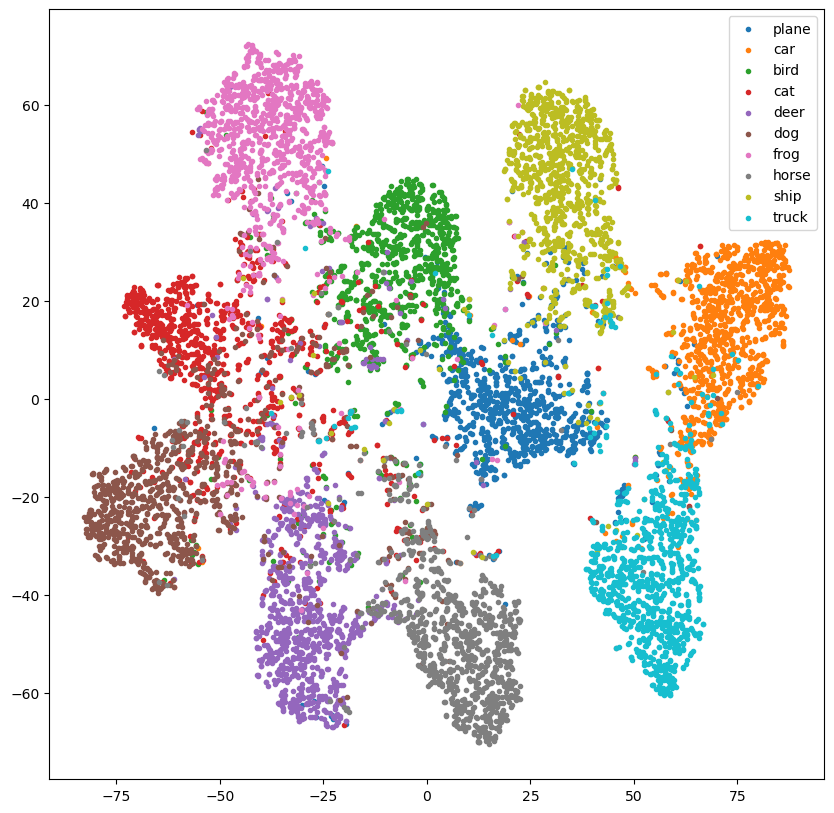

In [24]:
plt.figure(figsize=(10, 10)) # 10X10
cifar = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()